#What is going on in just one city?

I picked review_counts as a proxy for popularity since stars tend to be greatly influenced by the individual performance of the business and do not reflect the sole popularity of certain business category in the area. <br>
Of course, there are many factors that influence popularity, but the closest proxy in Yelp dataset is review_counts. <br>

The greatest issue I am facing now is dealing with the different volume of visitors in different areas of a city. It is well known that downtown is way more visited than some shop at the outer edge of the suburbs. 

In [1]:
#general
import numpy as np
import scipy
from matplotlib import pyplot as plt
%pylab inline
import pandas as pd
import MySQLdb
import os
import sys
sys.setrecursionlimit(3000)

Populating the interactive namespace from numpy and matplotlib


Let us get data.

In [3]:
con=MySQLdb.connect(user=user, passwd=passwd, db=dbname, host=host)
df2 = pd.read_sql("SELECT * FROM business WHERE state ='AZ' ", con)
print "data loaded"

data loaded


##Location Quotient

Location Quotient (LQ) is an indicator used in regional science and  planning to evaluate economic structure and specialty (Klosterman et. al., 1993). "The LQ is a measure which compares the relative importance (in terms of output or employment) of an business category in a region to its relative importance in the observed domain (Jensen, et. al., 1979)", so as to evaluate the deviation of region's business categories structure from that of the observed domain. A region showing greater than 1 of LQ for business category j is believed to be producing more than its share of  domain output in this business category j, and thus is defined as specialized in business category j.

$$LQ_{ij}=\frac{\frac{E_{ij}}{E_i}}{\frac{\sum_i E_{ij}}{\sum_i E_i}}$$
Where   
$E_{ij}$ is economic activity in subarea i, department j  
$E_i$ is total economic activity in subarea i   
$\sum_i E_{ij}$ is economic activity of department j in the whole area    
$\sum_i E_i$ is total economic activity in the whole area

In this analysis subarea is cluster, department is chosen business category, and the whole area is Phoenix. <br>
So let us start forming LQ.

In [9]:
EI_Ph = df2.review_count.sum()
lala = df2.groupby('categories').sum()
EI = lala.review_count
E_div = EI/EI_Ph

And, the denominator is done. 

To complete the rest of the variable, first the clusters need to be determined.

In [10]:
from sklearn.cluster import DBSCAN
from geopy.distance import great_circle
coordinates = df2.as_matrix(columns=['longitude', 'latitude'])

It is time for cluster detection. 

In [11]:
db = DBSCAN(eps=.006, min_samples=2).fit(coordinates)
labels = db.labels_
num_clusters = len(set(labels)) - (1 if -1 in labels else 0)
clusters = pd.Series([coordinates[labels == i] for i in xrange(num_clusters)])
print('Number of clusters: %d' % num_clusters)

Number of clusters: 1017


In [12]:
def getCentroid(points):
    n = points.shape[0]
    sum_lon = np.sum(points[:, 1])
    sum_lat = np.sum(points[:, 0])
    return (sum_lon/n, sum_lat/n)

In [13]:
def getNearestPoint(set_of_points, point_of_reference):
    closest_point = None
    closest_dist = None
    for point in set_of_points:
        point = (point[1], point[0])
        dist = great_circle(point_of_reference, point).meters
        if (closest_dist is None) or (dist < closest_dist):
            closest_point = point
            closest_dist = dist
    return closest_point

In [14]:
lon = []
lat = []
for i, cluster in clusters.iteritems():
    if len(cluster) < 3:
        representative_point = (cluster[0][1], cluster[0][0])
    else:
        representative_point = getNearestPoint(cluster, getCentroid(cluster))
    lon.append(representative_point[0])
    lat.append(representative_point[1])
rs = pd.DataFrame({'lon':lon, 'lat':lat})

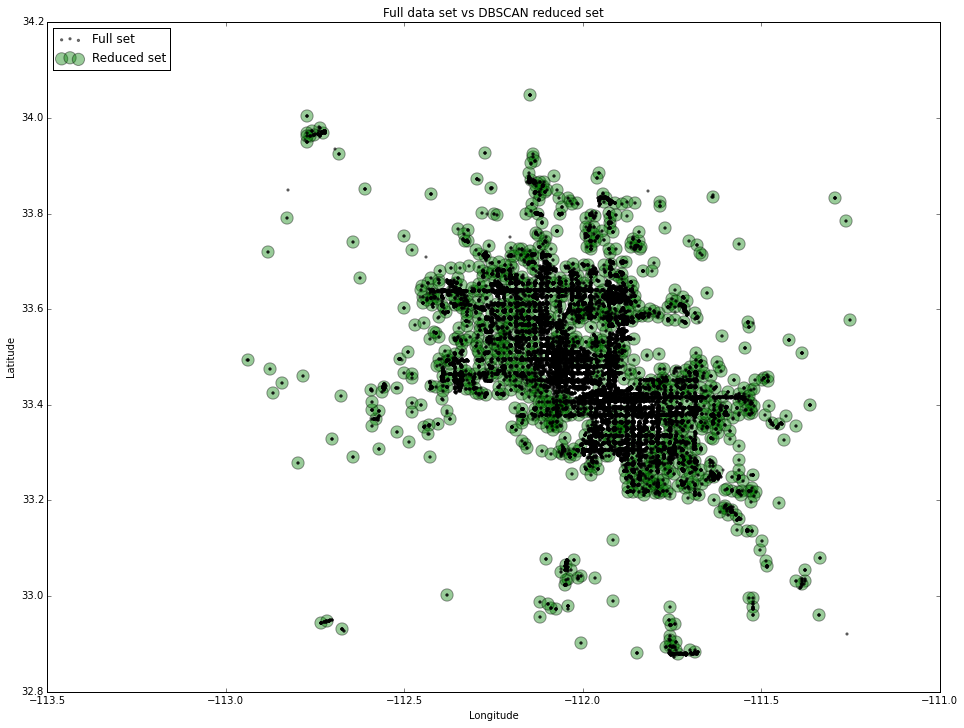

In [16]:
plt.figure(figsize=(16, 12), dpi=100)
rs_scatter = plt.scatter(rs['lat'], rs['lon'], c='g', alpha=.4, s=150)
df_scatter = plt.scatter(df2['longitude'], df2['latitude'], c='k', alpha=.5, s=5)
plt.title('Full data set vs DBSCAN reduced set')
plt.legend((df_scatter, rs_scatter), ('Full set', 'Reduced set'), loc='upper left')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

Add the column that denotes the cluster. 

In [17]:
df2['cluster']=0
i=0
for clus in clusters:
    for c in clus:
        df2.cluster.loc[(df2.longitude == c[0]) & (df2.latitude == c[1])]=i
    i=i+1

/Users/Lexa/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/Lexa/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/Users/Lexa/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#index

In [ ]:
query = "ALTER TABLE upload ADD %s INT(15)" % (cluster)
c.execute( query )

Add the column that denotes the denominator. 

In [19]:
df2['E_div']=0
i=0
for e in E_div:
    val=e
    cat=E_div.index[i]
    df2.E_div.loc[df2.categories==cat]=val
    i=i+1

/Users/Lexa/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/Lexa/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [20]:
df2['EI']=0
for c in df2.cluster.unique():
        suma = df2.review_count[df2.cluster == c].sum()
        df2.EI.loc[df2.cluster ==c]=suma
#train.head(5)

/Users/Lexa/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/Lexa/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Finally, calculating LQ.

In [22]:
df2['LQ'] = (df2.review_count/df2.EI)/df2.E_div

/Users/Lexa/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [23]:
df2.head(5)

,Unnamed: 0,X,categories,city,full_address,latitude,longitude,name,open,review_count,stars,state,type,zipcode,cluster,E_div,EI,LQ
0,1,0,Doctors,Phoenix,"Phoenix, AZ 85018",33.499313,-111.983758,"Eric Goldberg, MD",True,9,3.5,AZ,business,85018,3,0.002138,1151303,0.003656
1,2,1,Health & Medical,Phoenix,"Phoenix, AZ 85018",33.499313,-111.983758,"Eric Goldberg, MD",True,9,3.5,AZ,business,85018,3,0.006504,1151303,0.001202
2,3,5488,Sandwiches,Phoenix,"Phoenix, AZ 85004",33.479542,-112.073418,Domino's Pizza,True,11,3.0,AZ,business,85004,3,0.016915,1151303,0.000565
3,4,5489,Pizza,Phoenix,"Phoenix, AZ 85004",33.479542,-112.073418,Domino's Pizza,True,11,3.0,AZ,business,85004,3,0.021680,1151303,0.000441
4,5,5490,Chicken Wings,Phoenix,"Phoenix, AZ 85004",33.479542,-112.073418,Domino's Pizza,True,11,3.0,AZ,business,85004,3,0.002773,1151303,0.003445


In [ ]:
query = "ALTER TABLE upload ADD %s INT(15)" % (LQ)
c.execute( query )